# Eddy vizualisation and statistics with py-eddy-tracker

The aim of this notebook is to visualise and do some statiatical analysis on the py-eddy-tracker eddy identification and tracking results and compare them to the AVISO META 3.2 observations. The eddy ID and tracking is done in seperate notebook and tracked eddies are just read in here.


Although for visualisation the "normal" py-eddy-tracker package should work, this notebook uses the "updated" version of py-eedy-tracker that was improved by Aaron Wienkers during the first EERIE hackathon (Nov 2023). Link to the py-eddy-tracker updated version and how to use it - https://github.com/eerie-project/EERIE_hackathon_2023/tree/main/RESULTS/pyeddytracker_xarray_dask_parallel. 

**In this notebook large datasets are read in (although depends for how many years you identified eddies for) and I suggest getting the 256Gb compute session on levante.**
Additionally, reading in the dataset with the py-eddy-tracker package uses a lot of memory, for more memory efficient methods you can look yp the code examples by Malcom Roberts.




Created by: Stella Bērziņa (stella.berzina@usys.ethz.ch), uses mostly py-eddy-tracker package functions

Created: 23.05.2024

Last edited 11.06.2024

In [14]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import glob
import intake
from pathlib import Path
import dask
import pandas as pd
dask.config.set({"array.slicing.split_large_chunks": True}) 
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
import sys
from numpy import arange, ones

import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.cm import get_cmap
from matplotlib import colors 
from matplotlib.colors import ListedColormap
from matplotlib.figure import Figure
from matplotlib.ticker import FuncFormatter

from py_eddy_tracker.observations.network import NetworkObservations
from py_eddy_tracker.observations.observation import EddiesObservations, Table
from py_eddy_tracker.observations.tracking import TrackEddiesObservations
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.featured_tracking.area_tracker import AreaTracker
from py_eddy_tracker.gui import GUI
from py_eddy_tracker.tracking import Correspondances


from datetime import datetime, timedelta
from netCDF4 import Dataset

import io
import os

import warnings
warnings.filterwarnings("ignore")

# from concurrent.futures import ProcessPoolExecutor
# from concurrent.futures import ThreadPoolExecutor

import dask
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,LatitudeLocator)
import cartopy.feature as cfeature


import tol_colors as tc

## Read in tracked eddy dataset

If you have not identified and tracked eddies jet, please refer to the notebook XX.

Here I use tracked eddy dataset from ICON EERIE 1950 run (39 years of output) and AVISO observations (28 years of data). To create a smaller data subset, both datasets are time-filtered to include only eddies that have lifetimes >=16 weeks.

This takes a hot second.

In [2]:
c_16w = TrackEddiesObservations.load_file((
        "/work/bk1377/b382618/icon_malcom/16w/Cyclonic.nc")
)
a_16w = TrackEddiesObservations.load_file((
        "/work/bk1377/b382618/icon_malcom/16w/Anticyclonic.nc")
)

In [3]:
c_16wobs = TrackEddiesObservations.load_file((
        "/work/bk1377/b382618/icon_malcom/16w/aviso/Cyclonic.nc")
)
a_16wobs = TrackEddiesObservations.load_file((
        "/work/bk1377/b382618/icon_malcom/16w/aviso/Anticyclonic.nc")
)


## Eddy property maps

I use mostly py-eddy-tracker built in functions. I try to comment them here as much as possible. You can find more details on the functions here (https://py-eddy-tracker.readthedocs.io/en/stable/index.html )

In [24]:
lifetime=16 #change this when you read in different dataset
time_unit= "weeks"
step = 1 #step=the grid box over which you average eddy properties
Data_list = [a_16w, c_16w, a_16wobs, c_16wobs] #list of the 4 datasets that will occur in the plots

title_list = ["ICON anticyclonic",
              "ICON cyclonic",
              "AVISO anticyclonic",
              "AVISO cyclonic"]

#### Amplitude

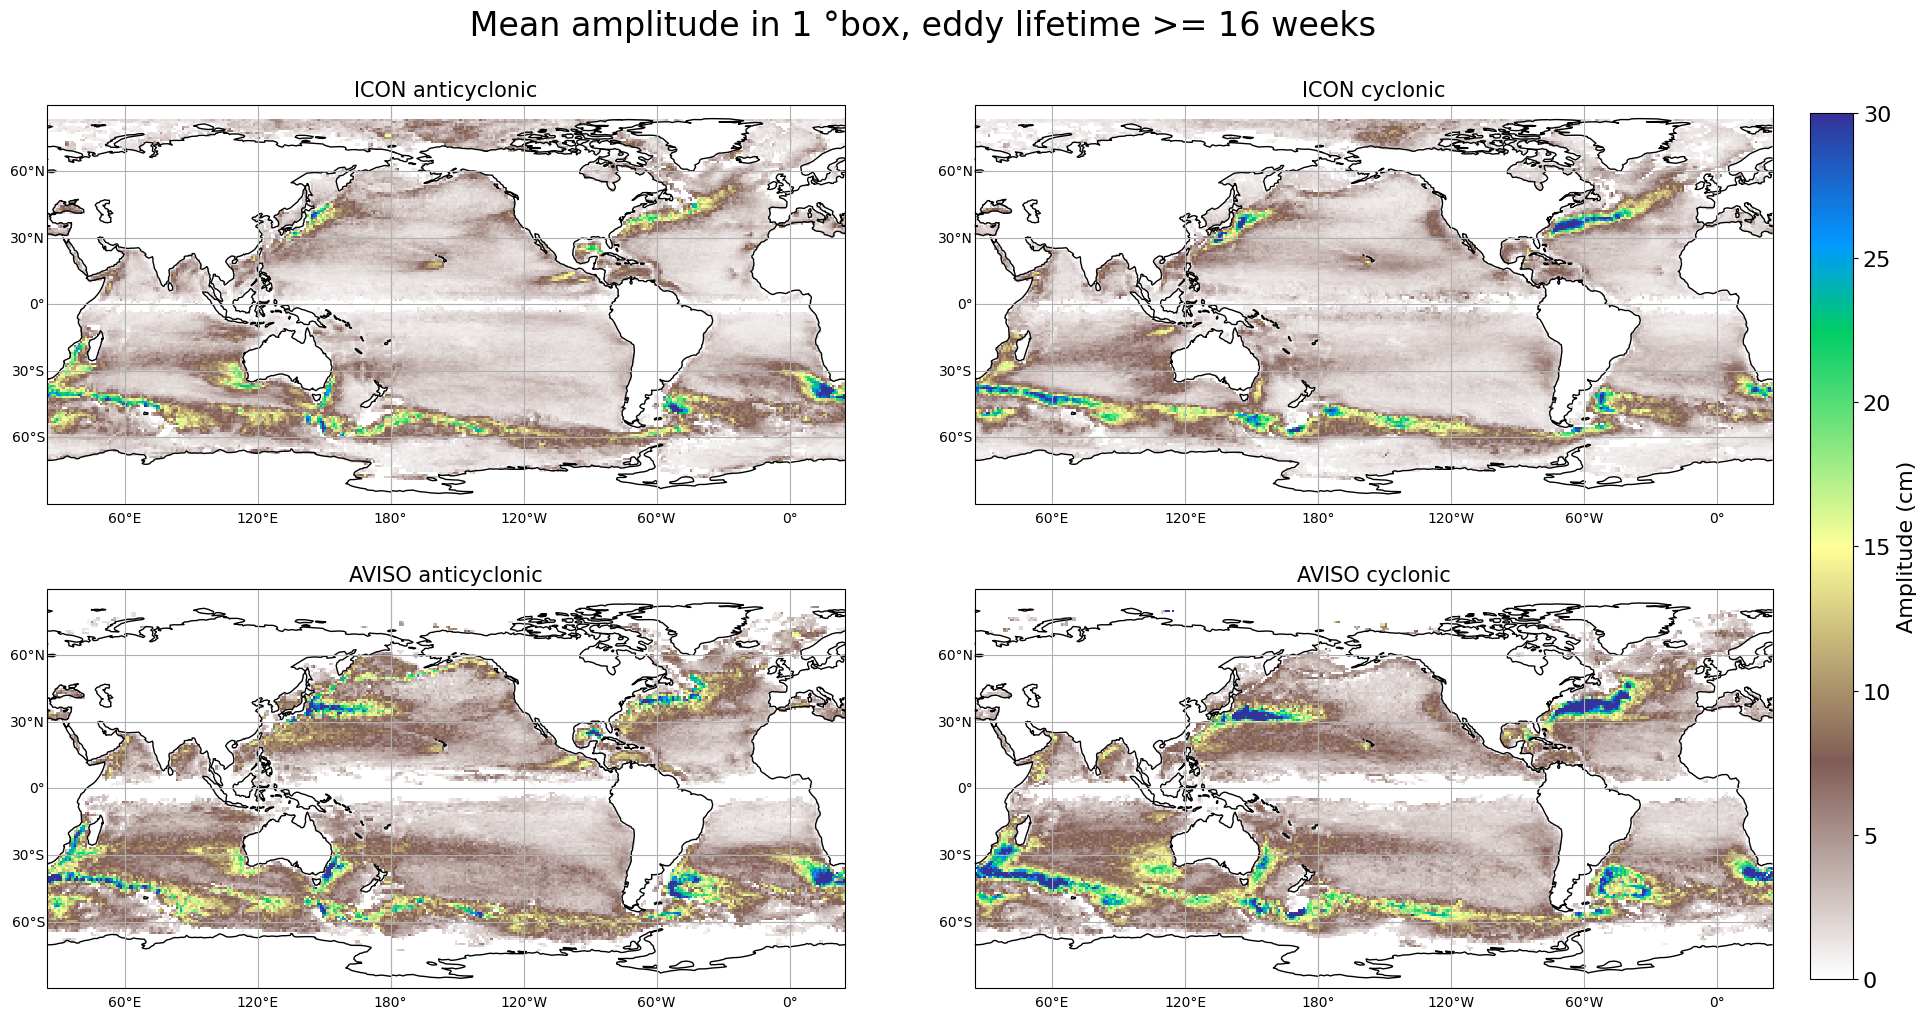

In [88]:

%matplotlib inline
lonshift = 205
proj=ccrs.PlateCarree(central_longitude = lonshift)
fig, ax = plt.subplots(2, 2, figsize=(20, 10), subplot_kw={'projection': proj},layout='constrained')

i=-1 #counter to itterate through datasets
for row in range(2):
    for col in range(2):
        i=i+1
        
        #all of this chunk sets up your maps
        ax[row][col].set_title(title_list[i] , fontsize=15)
        gl = ax[row][col].gridlines(draw_labels=True) # need cartopy version 0.18!!!
        gl.top_labels = False
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
        gl.xlabels_top = False
        gl.ylabels_right = False
        ax[row][col].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
        ax[row][col].add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)
        gl.xlabel_style = {'size': 10, 'color': 'k'}
        gl.ylabel_style = {'size': 10, 'color': 'k'}
        
        
        #here the property average in the gridcell is calculated and plotted
        g = Data_list[i].grid_stat(((-180, 180, step), (-85, 85, step)), "amplitude")
        m = g.display(ax[row][col], name="amplitude", ref=-10, vmin=0, vmax=30, factor=100, cmap="terrain_r",transform=ccrs.PlateCarree() )


        
cb = plt.colorbar(m, ax=ax.ravel().tolist(), shrink=0.98, pad=0.02)
cb.set_label("Amplitude (cm)")
fig.suptitle(' Mean amplitude in %s °box, eddy lifetime >= %s %s\n '% (step, lifetime, time_unit), fontsize=24)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0, wspace=0, hspace=0.08) #create somewhat spacing between plots



# plt.savefig('/home/b/b3826180/eddy_figs/model_evaluation/icon_aviso_16w_amplitude.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


### Radius

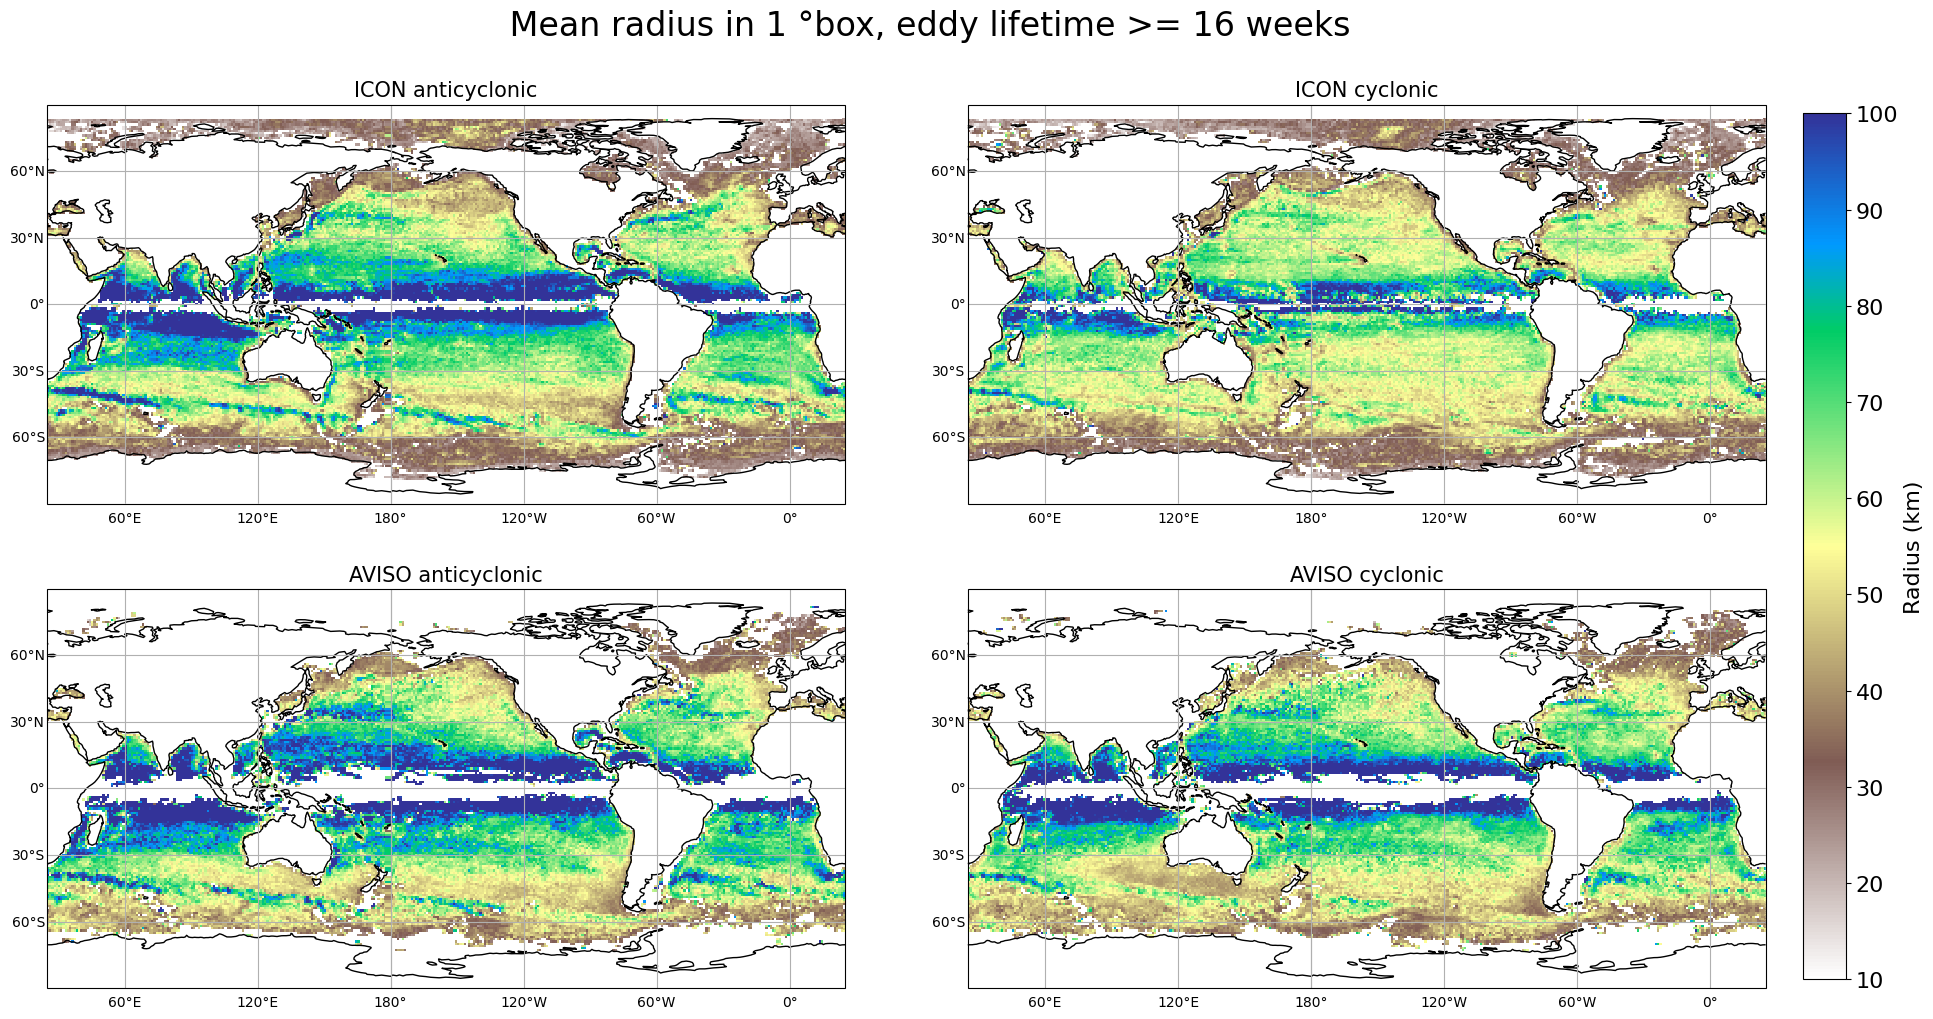

In [91]:

%matplotlib inline
lonshift = 205
proj=ccrs.PlateCarree(central_longitude = lonshift)
fig, ax = plt.subplots(2, 2, figsize=(20, 10), subplot_kw={'projection': proj}, layout='constrained')
i=-1 #counter to itterate through datasets
for row in range(2):
    for col in range(2):
        i=i+1
       #all of this chunk sets up your maps
        ax[row][col].set_title(title_list[i] , fontsize=15)
        gl = ax[row][col].gridlines(draw_labels=True) # need cartopy version 0.18!!!
        gl.top_labels = False
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
        gl.xlabels_top = False
        gl.ylabels_right = False
        ax[row][col].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
        ax[row][col].add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)
        gl.xlabel_style = {'size': 10, 'color': 'k'}
        gl.ylabel_style = {'size': 10, 'color': 'k'}
        
        
        #here the property average in the gridcell is calculated and plotted
        g = Data_list[i].grid_stat(((-180, 180, step), (-85, 85, step)), "radius_s")
        m = g.display(ax[row][col], name="radius_s", ref=-10, vmin=10, vmax=100, factor=0.001, cmap="terrain_r",transform=ccrs.PlateCarree() )


cb = plt.colorbar(m, ax=ax.ravel().tolist(), shrink=0.98, pad=0.02)
cb.set_label("Radius (km)")
fig.suptitle(' Mean radius in %s °box, eddy lifetime >= %s %s\n '% (step, lifetime, time_unit), fontsize=24)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0, wspace=0, hspace=0.08) #create somewhat spacing between plots


# plt.savefig('/home/b/b3826180/eddy_figs/model_evaluation/icon_aviso_16w_radius.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


### Shape error

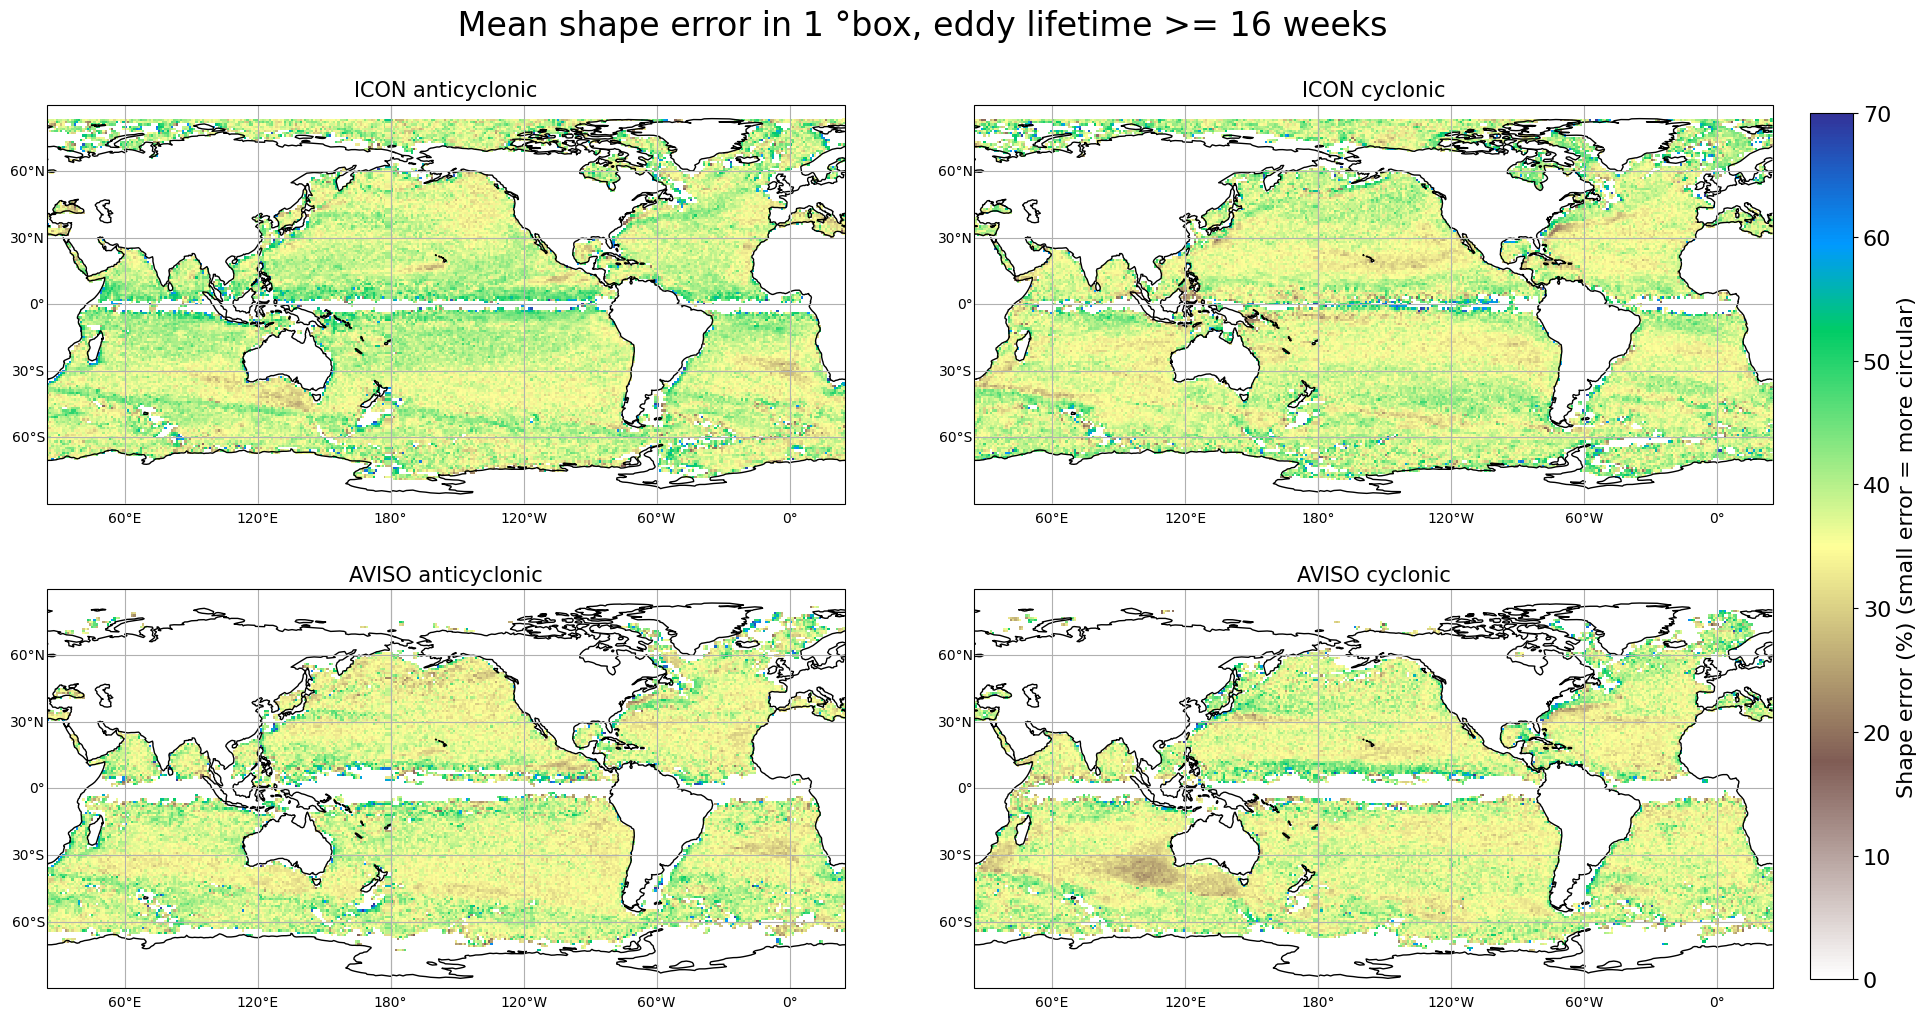

In [94]:

%matplotlib inline
lonshift = 205
proj=ccrs.PlateCarree(central_longitude = lonshift)
fig, ax = plt.subplots(2, 2, figsize=(20,10), subplot_kw={'projection': proj}, layout='constrained')
i=-1 #counter to itterate through datasets
for row in range(2):
    for col in range(2):
        i=i+1
        
        #all of this chunk sets up your maps
        ax[row][col].set_title(title_list[i], fontsize=15)
        gl = ax[row][col].gridlines(draw_labels=True) # need cartopy version 0.18!!!
        gl.top_labels = False
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
        gl.xlabels_top = False
        gl.ylabels_right = False
        ax[row][col].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
        gl.xlabel_style = {'size': 10, 'color': 'k'}
        gl.ylabel_style = {'size': 10, 'color': 'k'}
        ax[row][col].add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)
        
        #here the property average in the gridcell is calculated and plotted
        g = Data_list[i].grid_stat(((-180, 180, step), (-85, 85, step)), "shape_error_e")
        m = g.display(ax[row][col], name="shape_error_e", ref=-10, vmin=0, vmax=70, factor=1, cmap="terrain_r",transform=ccrs.PlateCarree() )
        plt.rcParams["font.size"] = "16"

cb = plt.colorbar(m, ax=ax.ravel().tolist(), shrink=0.98, pad=0.02)
cb.set_label("Shape error (%) (small error = more circular)")
fig.suptitle(' Mean shape error in %s °box, eddy lifetime >= %s %s\n '% (step, lifetime, time_unit), fontsize=24)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0, wspace=0, hspace=0.08) #create somewhat spacing between plots

    
# plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/icon_aviso_16w_shape_error.png', dpi=300, bbox_inches='tight', pad_inches=0.2)


#### you can do the above plots with all other variables avaliable for tracked eddies from py-eddy-tracker

## Eddy birth and death

This function counts the CENTRES of eddies that are in each of the gridbox. 

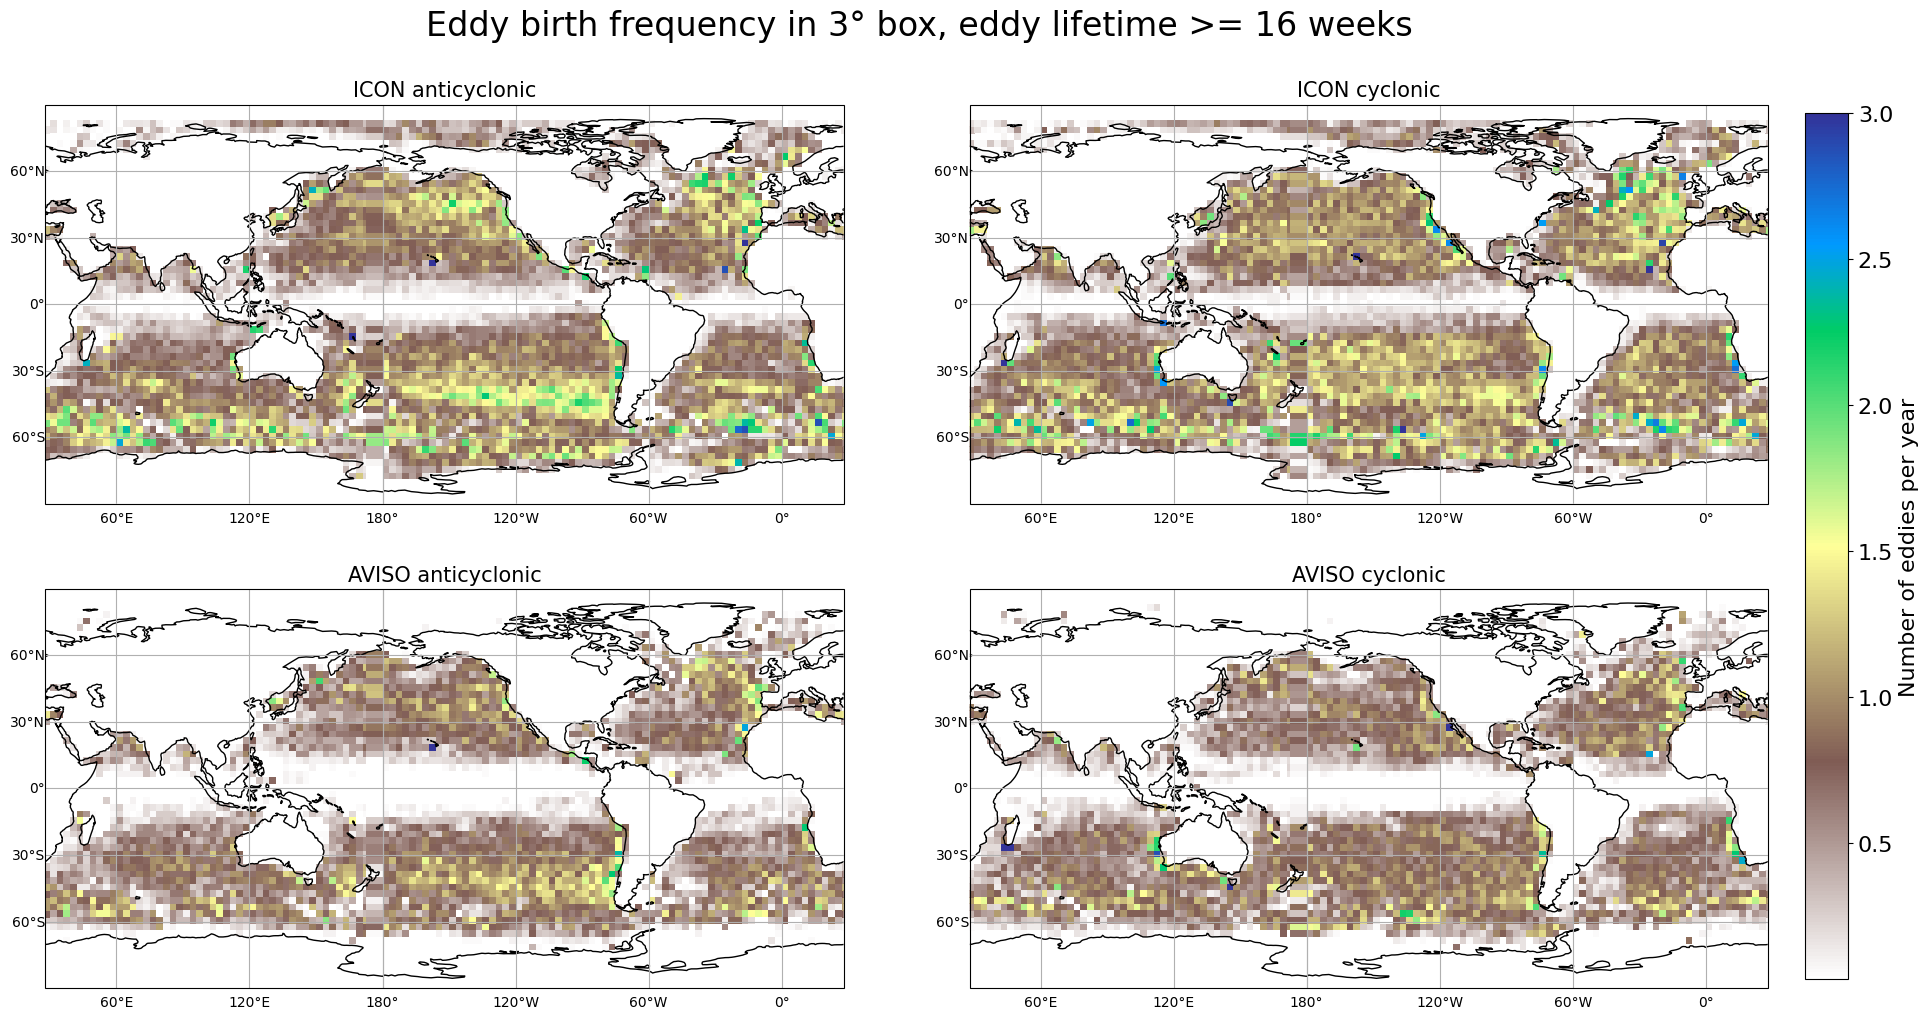

In [96]:
step = 3 #overrides the previous step
bins = ((-180, 180, step), (-85, 85, step))

%matplotlib inline
lonshift = 208
proj=ccrs.PlateCarree(central_longitude = lonshift)
fig, ax = plt.subplots(2, 2, figsize=(20, 10), subplot_kw={'projection': proj}, layout='constrained')

i=-1 #counter to itterate through datasets
for row in range(2):
    for col in range(2):
        i=i+1
        
        #all of this chunk sets up your maps
        ax[row][col].set_title(title_list[i], fontsize=15)
        gl = ax[row][col].gridlines(draw_labels=True) # need cartopy version 0.18!!!
        gl.top_labels = False
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
        gl.xlabels_top = False
        gl.ylabels_right = False
        ax[row][col].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
        gl.xlabel_style = {'size': 10, 'color': 'k'}
        gl.ylabel_style = {'size': 10, 'color': 'k'}
        ax[row][col].add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)
        
        # This is for calculating the frequency per year rather than the absolute number of events in the time period
        t0, t1 = Data_list[i].period
        years= int((t1-t0)/365)
        kwargs = dict(cmap="terrain_r", name="count", factor=1/years, vmax=3)
        
        #here you actually calculate ans plot eddy birth
        g_c_first = Data_list[i].first_obs().grid_count(bins, intern=True, center=True)
        m = g_c_first.display(ax[row][col], **kwargs, transform=ccrs.PlateCarree(),ref=-10)

cb = plt.colorbar(m, ax=ax.ravel().tolist(), shrink=0.98, pad=0.02)
cb.set_label("Number of eddies per year")
fig.suptitle('Eddy birth frequency in %s° box, eddy lifetime >= %s %s\n '% (step, lifetime, time_unit), fontsize=24)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0, wspace=0, hspace=0.08) #create somewhat spacing between plots

    
# plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/icon_aviso_16w_birth.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


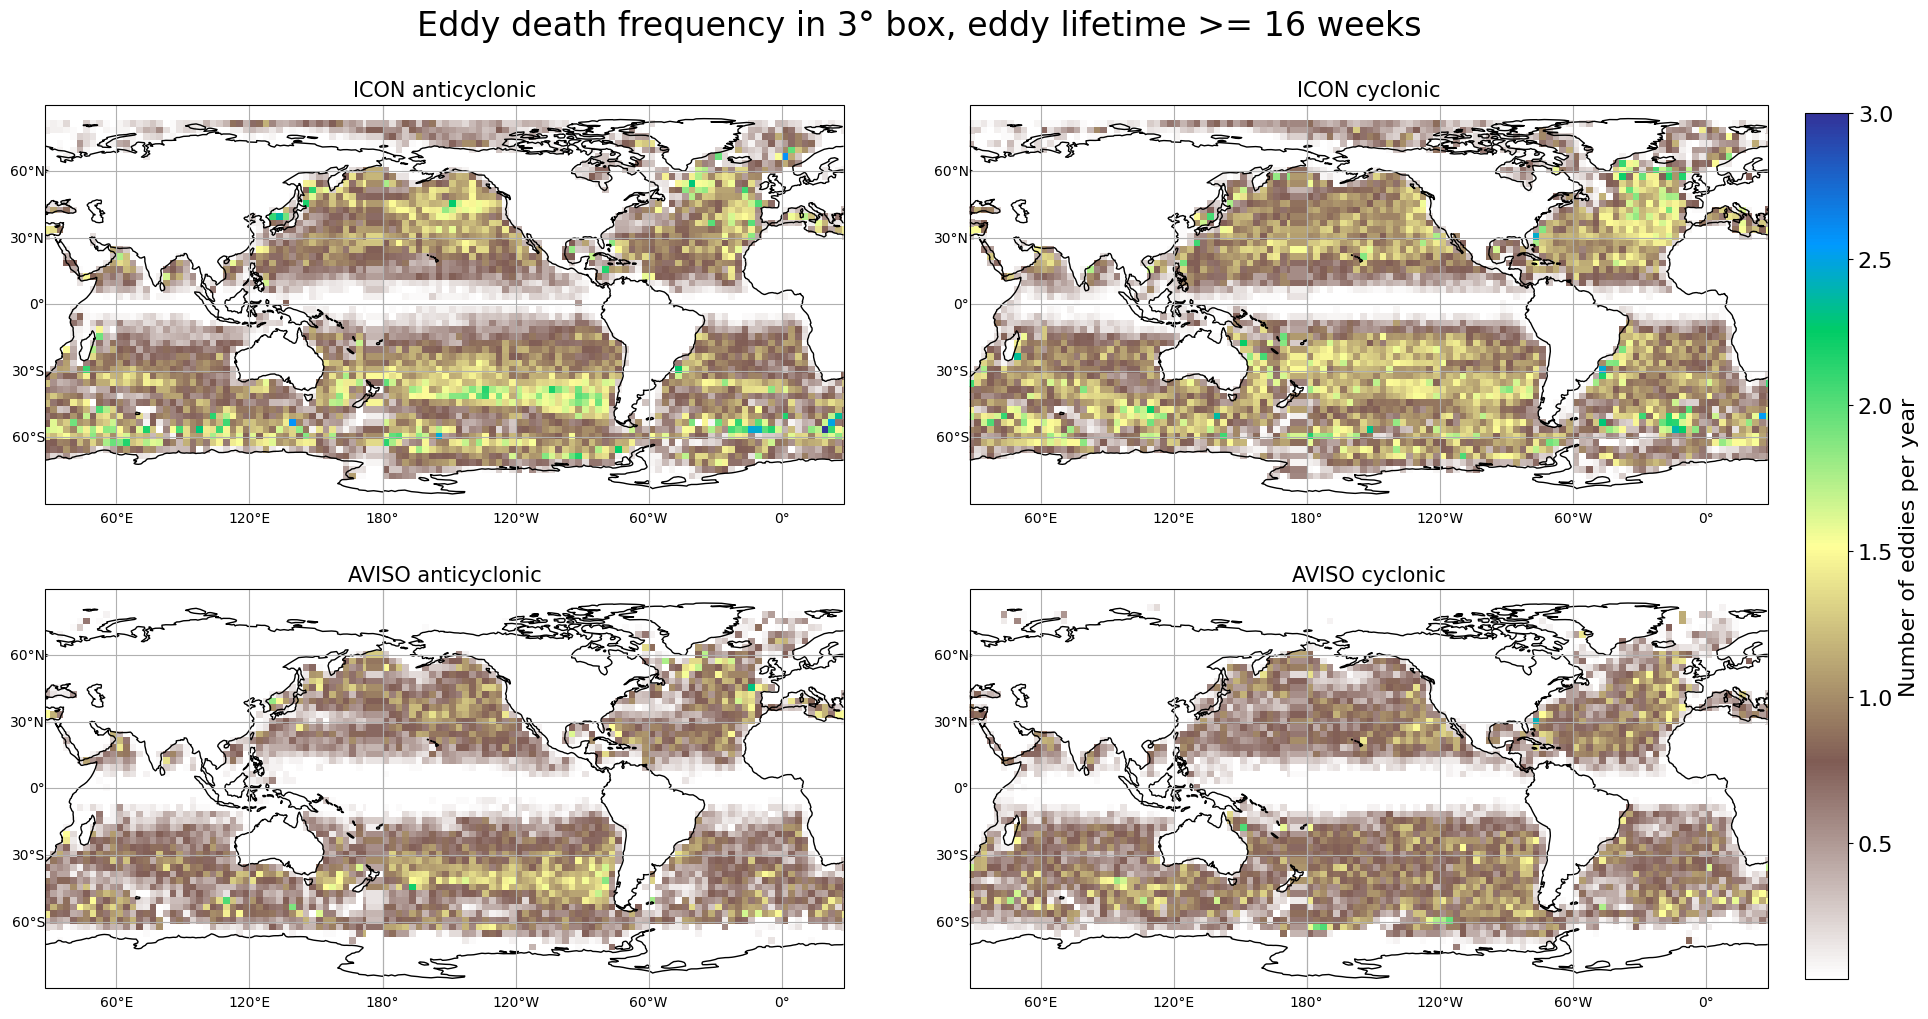

In [98]:
step = 3 #overrides the previous step
bins = ((-180, 180, step), (-85, 85, step))

%matplotlib inline
lonshift = 208
proj=ccrs.PlateCarree(central_longitude = lonshift)
fig, ax = plt.subplots(2, 2, figsize=(20, 10), subplot_kw={'projection': proj}, layout='constrained')

i=-1 #counter to itterate through datasets
for row in range(2):
    for col in range(2):
        i=i+1
        
        #all of this chunk sets up your maps
        ax[row][col].set_title(title_list[i], fontsize=15)
        gl = ax[row][col].gridlines(draw_labels=True) # need cartopy version 0.18!!!
        gl.top_labels = False
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
        gl.xlabels_top = False
        gl.ylabels_right = False
        ax[row][col].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
        gl.xlabel_style = {'size': 10, 'color': 'k'}
        gl.ylabel_style = {'size': 10, 'color': 'k'}
        ax[row][col].add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)
        
        # This is for calculating the frequency per year rather than the absolute number of events in the time period
        t0, t1 = Data_list[i].period
        years= int((t1-t0)/365)
        kwargs = dict(cmap="terrain_r", name="count", factor=1/years, vmax=3)
        
        #here you actually calculate ans plot eddy birth
        g_c_first = Data_list[i].last_obs().grid_count(bins, intern=True, center=True)
        m = g_c_first.display(ax[row][col], **kwargs, transform=ccrs.PlateCarree(),ref=-10)

cb = plt.colorbar(m, ax=ax.ravel().tolist(), shrink=0.98, pad=0.02)
cb.set_label("Number of eddies per year")
fig.suptitle('Eddy death frequency in %s° box, eddy lifetime >= %s %s\n '% (step, lifetime, time_unit), fontsize=24)
fig.set_constrained_layout_pads(w_pad=0.0, h_pad=0, wspace=0, hspace=0.08) #create somewhat spacing between plots

    
# plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/icon_aviso_16w_death.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


## Eddy occurrence frequency

This function counts the CENTRES of eddies that are in each of the gridbox. 

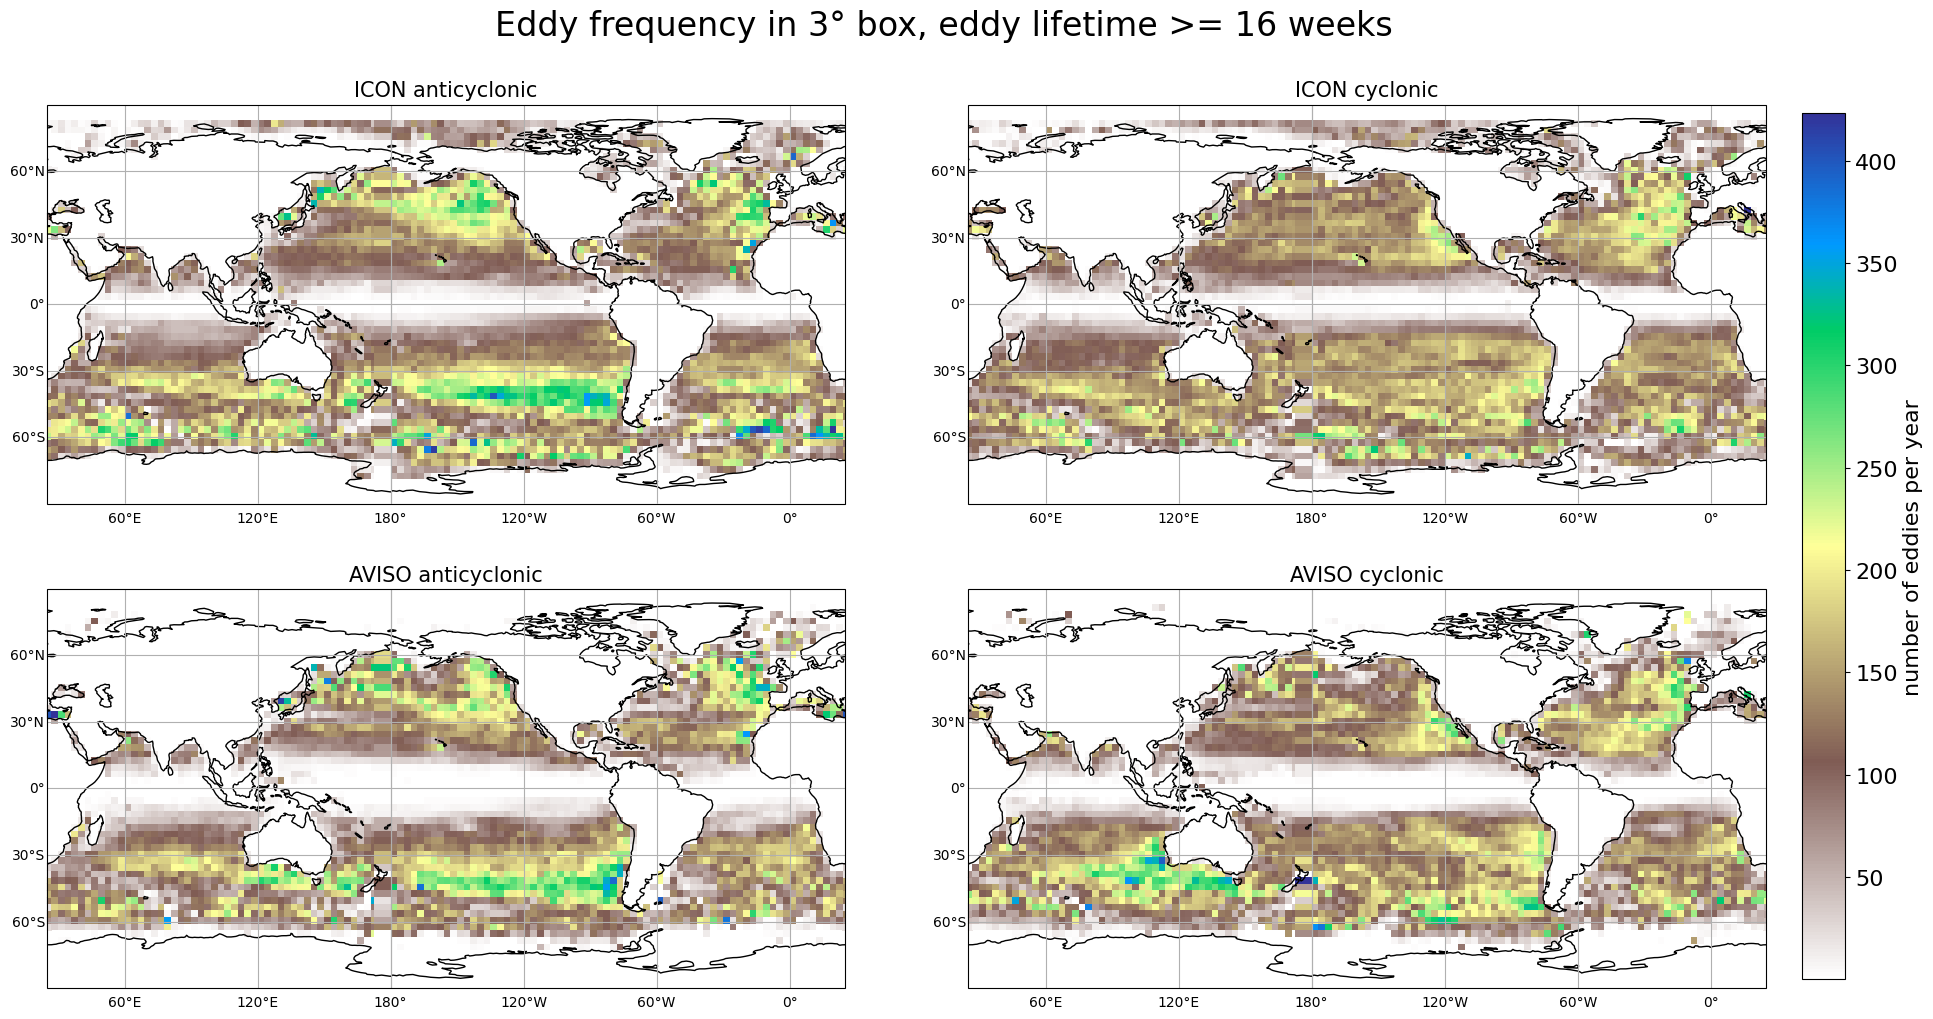

In [104]:

%matplotlib inline
lonshift = 205
proj=ccrs.PlateCarree(central_longitude = lonshift)
fig, ax = plt.subplots(2, 2, figsize=(20, 10), subplot_kw={'projection': proj}, layout='constrained')
i=-1 #counter to itterate through datasets
for row in range(2):
    for col in range(2):
        i=i+1
        # title=title_list[i]
        ax[row][col].set_title(title_list[i], fontsize=15)
        gl = ax[row][col].gridlines(draw_labels=True) # need cartopy version 0.18!!!
        gl.top_labels = False
        gl.xformatter = LongitudeFormatter()
        gl.yformatter = LatitudeFormatter()
        gl.xlabels_top = False
        gl.ylabels_right = False
        ax[row][col].set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
        gl.xlabel_style = {'size': 10, 'color': 'k'}
        gl.ylabel_style = {'size': 10, 'color': 'k'}

        ax[row][col].add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=1)
        
        # This is for calculating the frequency rather than the absolute number of events in the time period
        t0, t1 = Data_list[i].period
        years= int((t1-t0)/365)
        kwargs = dict(cmap="terrain_r", name="count", factor=1/years) # factor is multiplied by each gridcell value
        
        g_c_first = Data_list[i].grid_count(bins, intern=True, center=True)
        m = g_c_first.display(ax[row][col], **kwargs, transform=ccrs.PlateCarree(),ref=-50)


cb = plt.colorbar(m, ax=ax.ravel().tolist(), shrink=0.98, pad=0.02)
cb.set_label("Number of eddies per year")
fig.suptitle('Eddy frequency in %s° box, eddy lifetime >= %s %s\n '% (step, lifetime, time_unit), fontsize=24)
fig.set_constrained_layout_pads(w_pad=0.2, h_pad=0, wspace=0, hspace=0.08) #create somewhat spacing between plots

    
# plt.savefig('/home/b/b382618/eddy_figs/model_0evaluation/icon_aviso_16w_number.png', dpi=300, bbox_inches='tight', pad_inches=0.2)


## Zonal means of eddy properties

Here I zonally average for every 1 degree of latitude eddy properties and make a pandas df for this data. Takes a sec to run (~15 mins?). Ideas for making it faster are welcome

### Radius

In [15]:
column_list = ['a', 'c', 'a_obs', 'c_obs']
zonal_mean = pd.DataFrame(columns=["lat", column_list[0],column_list[1], column_list[2], column_list[3] ])
lat_bins=np.arange(-85,85,1)

for z in range(len(Data_list)):
    for i in range(len(lat_bins)-1):
        x0, x1, y0, y1 = 0, 360, lat_bins[i], lat_bins[i+1]
        area = dict(llcrnrlon=x0, llcrnrlat=y0, urcrnrlon=x1, urcrnrlat=y1)
        a_subset = Data_list[z].extract_with_area(area, full_path=True)
        m=a_subset.speed_radius.mean() #here you can chose whichever variable you want
        zonal_mean.loc[len(zonal_mean)] = ({'lat': y0, str(column_list[z]): m}) 
    

Text(0.5, 1.0, 'Eddy (speed) radius zonal mean\n eddy lifeime >= 16 weeks')

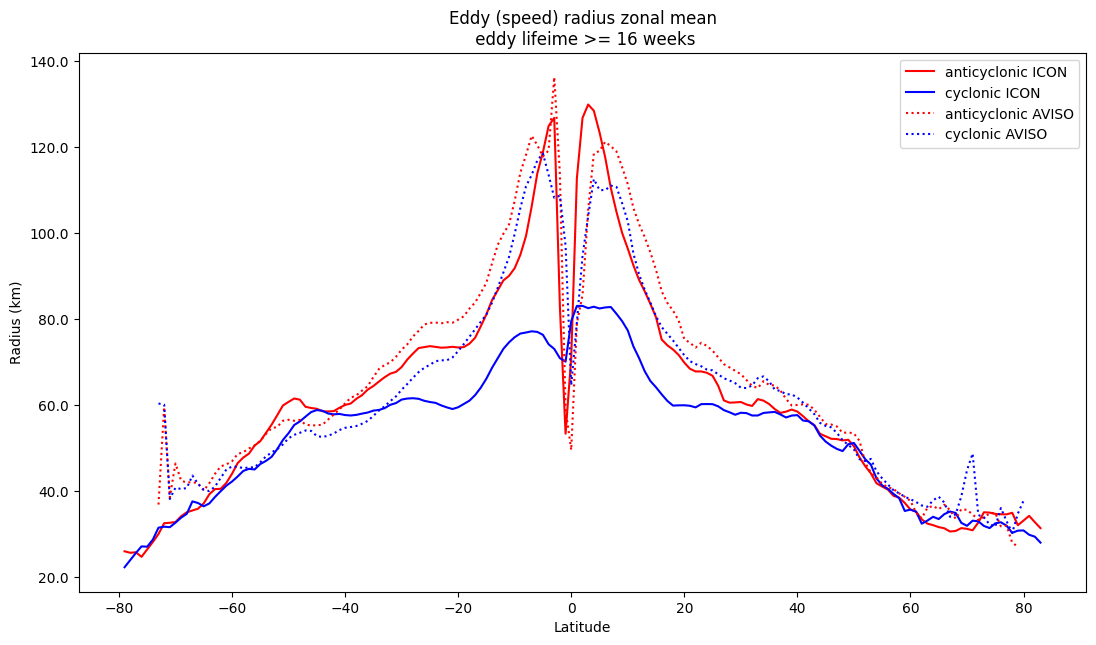

In [17]:
df=zonal_mean

fig, ax = plt.subplots(1, 1, figsize=(13, 7))

df.plot(ax=ax, x="lat", y='a', color='r', label='anticyclonic ICON')      
df.plot(ax=ax, x="lat", y='c', color='b', label='cyclonic ICON')
df.plot(ax=ax, x="lat", y='a_obs', color='r', linestyle='dotted', label='anticyclonic AVISO')
df.plot(ax=ax, x="lat", y='c_obs', color='b', linestyle='dotted', label='cyclonic AVISO')

# ytikcs
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: ('%.1f')%(x*1e-3)))
ax.set_ylabel('Radius (km)')
ax.set_xlabel('Latitude')
ax.set_title('Eddy (speed) radius zonal mean\n eddy lifeime >= 16 weeks')

# plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/icon_aviso_16w_zonal_mean_speed_radius.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


### Amplitude

In [21]:
zonal_mean = pd.DataFrame(columns=["lat", column_list[0],column_list[1], column_list[2], column_list[3] ])
lat_bins=np.arange(-85,85,1)

for z in range(len(Data_list)):
    for i in range(len(lat_bins)-1):
        x0, x1, y0, y1 = 0, 360, lat_bins[i], lat_bins[i+1]
        area = dict(llcrnrlon=x0, llcrnrlat=y0, urcrnrlon=x1, urcrnrlat=y1)
        a_subset = Data_list[z].extract_with_area(area, full_path=True)
        m=a_subset.amplitude.mean()
        zonal_mean.loc[len(zonal_mean)] = ({'lat': y0, str(column_list[z]): m}) 
    

Text(0.5, 1.0, 'Eddy anplitude mean\n eddy lifeime >= 16 weeks')

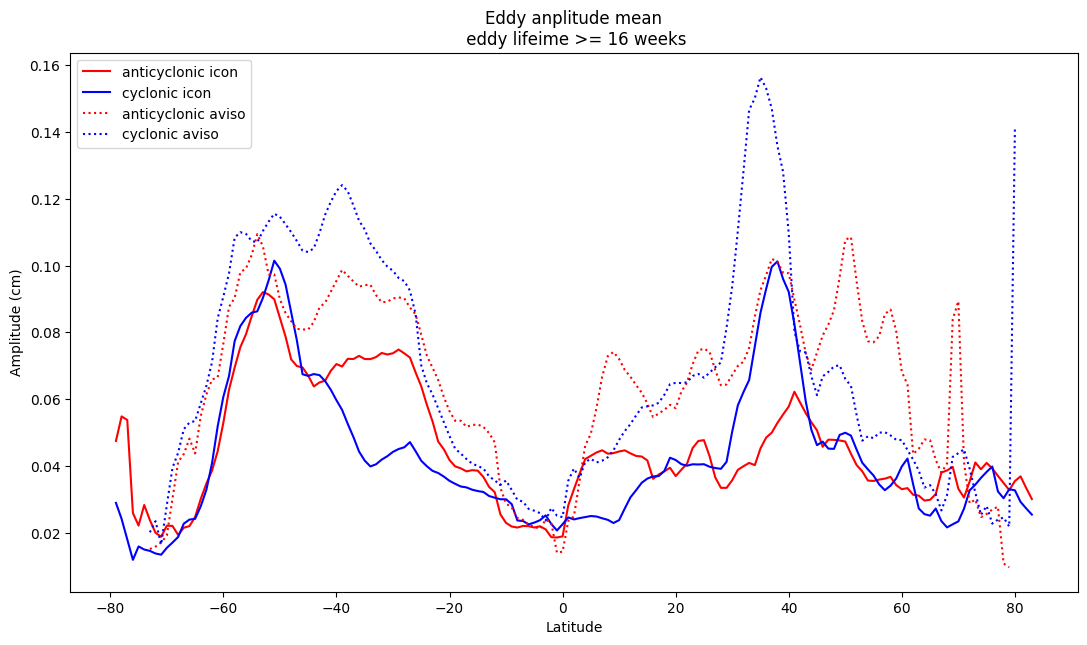

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(13, 7))

zonal_mean.plot(ax=ax, x="lat", y='a', color='r', label='anticyclonic icon')      
zonal_mean.plot(ax=ax, x="lat", y='c', color='b', label='cyclonic icon')
zonal_mean.plot(ax=ax, x="lat", y='a_obs', color='r', linestyle='dotted', label='anticyclonic aviso')
zonal_mean.plot(ax=ax, x="lat", y='c_obs', color='b', linestyle='dotted', label='cyclonic aviso')

ax.set_ylabel('Amplitude (cm)')
ax.set_xlabel('Latitude')
ax.set_title('Eddy anplitude mean\n eddy lifeime >= 16 weeks')

# plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/icon_aviso_16w_zonal_mean_amplitude.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


## Eddy property histograms

Text(0.57, 1.05, 'Eddy properties, eddy lifetime >= 16 weeks\n ')

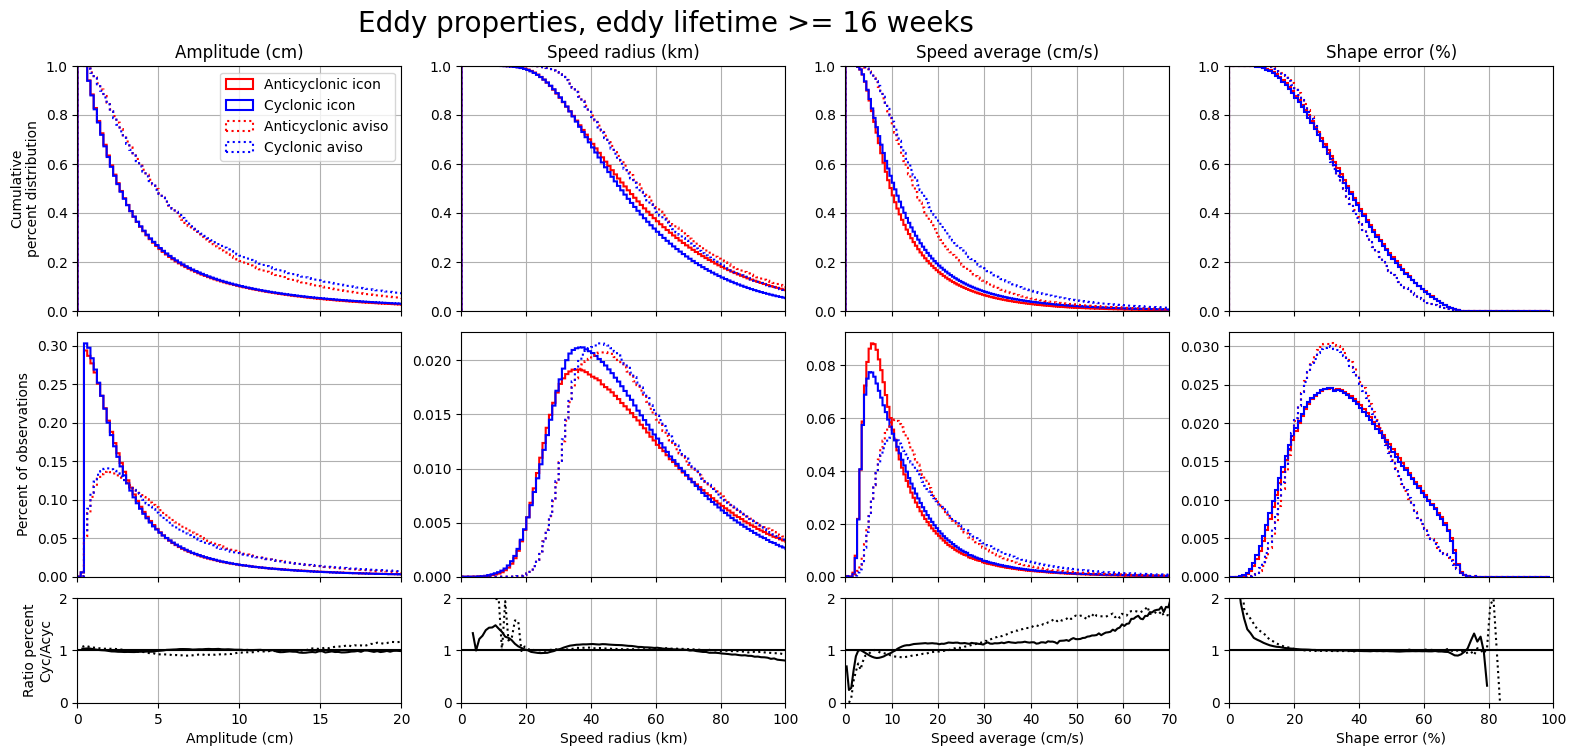

In [27]:
# This is slightly modified version of the plotting code that the py-eddy-tracking package provides. 

fig = plt.figure(figsize=(12, 7))
aadt=a_16w
cadt=c_16w
assh=a_16wobs
cssh=c_16wobs

kwargs_aadt = dict(label="Anticyclonic icon", color="red", histtype="step", density=True, linewidth=1.5) #a
kwargs_cadt = dict(label="Cyclonic icon", color='blue', histtype="step", density=True, linewidth=1.5) #c
kwargs_assh = dict(label="Anticyclonic aviso", color="red", histtype="step", density=True, linewidth=1.5, linestyle="dotted") #ao
kwargs_cssh = dict(label="Cyclonic aviso", color="blue", histtype="step", density=True, linewidth=1.5, linestyle="dotted") #co

for x0, name, title, xmax, factor, bins in zip(
    (1.04, 0.4, 0.72, 0.08), #this line makes them appear in a different sequence than defined
    ("effective_contour_shape_error", "speed_radius", "speed_average", "amplitude"),
    ( "Shape error (%)", "Speed radius (km)", "Speed average (cm/s)", "Amplitude (cm)"),
    (100, 100, 70, 20),
    (1, 0.001, 100, 100),
    ( arange(0,100,1), arange(0, 2000, 1), arange(0, 1000, 0.5), arange(0.0005, 1000, 0.2)),
):
    ax_hist = fig.add_axes((x0, 0.24, 0.27, 0.35)) #the last numbet makes the middle plots longer if you incease them
    nb_aadt, _, _ = ax_hist.hist(aadt[name] * factor, bins=bins, **kwargs_aadt)
    nb_cadt, _, _ = ax_hist.hist(cadt[name] * factor, bins=bins, **kwargs_cadt)
    nb_assh, _, _ = ax_hist.hist(assh[name] * factor, bins=bins, **kwargs_assh)
    nb_cssh, _, _ = ax_hist.hist(cssh[name] * factor, bins=bins, **kwargs_cssh)
    ax_hist.set_xticklabels([])
    ax_hist.set_xlim(0, xmax)
    ax_hist.grid()

    ax_cum = fig.add_axes((x0, 0.62, 0.27, 0.35))
    ax_cum.hist(aadt[name] * factor, bins=bins, cumulative=-1, **kwargs_aadt)
    ax_cum.hist(cadt[name] * factor, bins=bins, cumulative=-1, **kwargs_cadt)
    ax_cum.hist(assh[name] * factor, bins=bins, cumulative=-1, **kwargs_assh)
    ax_cum.hist(cssh[name] * factor, bins=bins, cumulative=-1, **kwargs_cssh)
    ax_cum.set_xticklabels([])
    ax_cum.set_title(title)
    ax_cum.set_xlim(0, xmax)
    ax_cum.set_ylim(0, 1)
    ax_cum.grid()

    ax_ratio = fig.add_axes((x0, 0.06, 0.27, 0.15))
    ax_ratio.set_xlim(0, xmax)
    ax_ratio.set_ylim(0, 2)
    ax_ratio.plot((bins[1:] + bins[:-1]) / 2, nb_cadt / nb_aadt, color='black', linewidth=1.5)
    ax_ratio.plot((bins[1:] + bins[:-1]) / 2, nb_cssh / nb_assh, color='black', linewidth=1.5, linestyle="dotted")
    ax_ratio.axhline(1, color="k")
    ax_ratio.grid()
    ax_ratio.set_xlabel(title)

ax_cum.set_ylabel("Cumulative\npercent distribution")
ax_hist.set_ylabel("Percent of observations")
ax_ratio.set_ylabel("Ratio percent\nCyc/Acyc")
ax_cum.legend()
plt.suptitle('Eddy properties, eddy lifetime >= %s %s\n '% (lifetime, time_unit), fontsize=20, y=1.05, x=0.57, )

# plt.savefig('/home/b/b3826180/eddy_figs/model_evaluation/icon_aviso_10d_eddy_properties.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

Text(0.5, 1.05, 'Eddies with lifetime >= 16 weeks\n ')

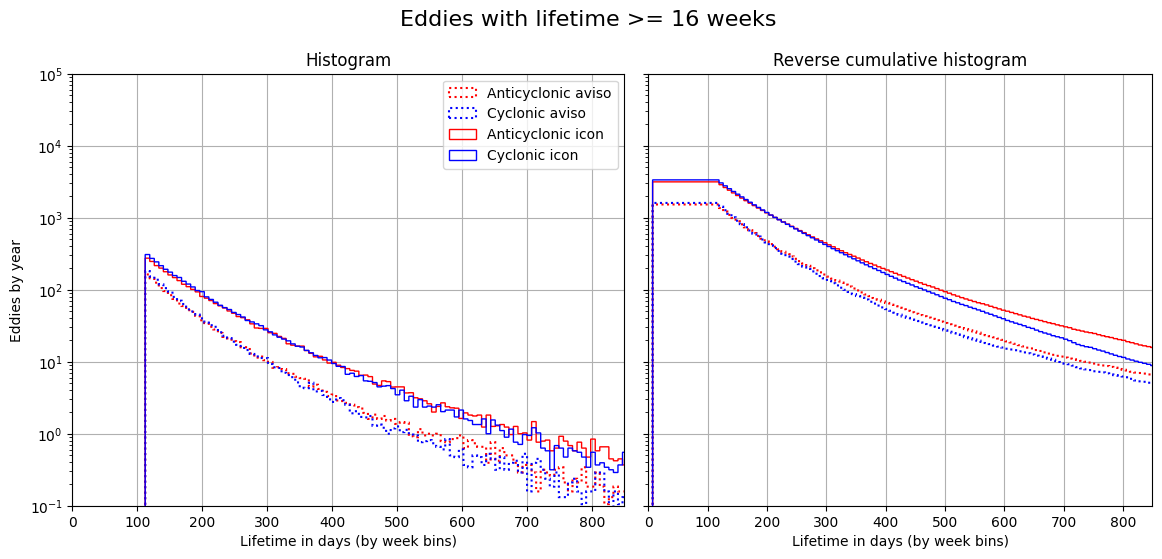

In [30]:
#set up axis

figure = plt.figure(figsize=(12, 8))
# ax_ratio_cum = figure.add_axes([0.55, 0.06, 0.42, 0.34])
# ax_ratio = figure.add_axes([0.07, 0.06, 0.46, 0.34])
ax_cum = figure.add_axes([0.55, 0.43, 0.42, 0.54])
ax = figure.add_axes([0.07, 0.43, 0.46, 0.54])
ax.set_ylabel("Eddies by year")

ax_cum.set_xlabel("Lifetime in days (by week bins)")
ax.set_xlabel("Lifetime in days (by week bins)")

ax.set_xlim(0, 360)
ax_cum.set_xlim(0, 360)

#ax_ratio.set_ylabel("Ratio Cyclonic/Anticyclonic")
for ax_ in (ax, ax_cum):
    ax_.set_xlim(0, 850)
    if ax_ in (ax, ax_cum):
        ax_.set_ylim(1e-1, 1e5), ax_.set_yscale("log")
    else:
        ax_.set_xlabel("Lifetime in days (by week bins)")
        ax_.set_ylim(0, 2)
        ax_.axhline(1, color="g", lw=2)
    ax_.grid()
#ax_cum.xaxis.set_ticklabels([]) 
ax_cum.yaxis.set_ticklabels([])
#ax.xaxis.set_ticklabels([])
#ax_ratio_cum.yaxis.set_ticklabels([])
ax_cum.set_title('Reverse cumulative histogram')
ax.set_title('Histogram')


cssh=c_16w
assh=a_16w
cadt=c_16wobs
aadt=a_16wobs

# aadt=a_adt
nb_year = (assh.period[1] - assh.period[0] + 1) / 365.25


# plot data
bin_hist = arange(7, 4000, 7)
x = (bin_hist[1:] + bin_hist[:-1]) / 2.0
a_nb, c_nb, a_nb2, c_nb2 = assh.nb_obs_by_track, cssh.nb_obs_by_track, aadt.nb_obs_by_track, cadt.nb_obs_by_track
a_nb, c_nb, a_nb2, c_nb2 = a_nb[a_nb != 0], c_nb[c_nb != 0], a_nb2[a_nb2 != 0], c_nb2[c_nb2 != 0]
w_a, w_c, w_a2, w_c2 = ones(a_nb.shape) / nb_year, ones(c_nb.shape) / nb_year, ones(a_nb2.shape) / nb_year, ones(c_nb2.shape) / nb_year
kwargs_assh = dict(histtype="step", bins=bin_hist, x=a_nb, color="red", weights=w_a)
kwargs_cssh = dict(histtype="step", bins=bin_hist, x=c_nb, color="blue", weights=w_c)
kwargs_aadt = dict(histtype="step", bins=bin_hist, x=a_nb2, color="red", weights=w_a2, linestyle="dotted", linewidth=1.5)
kwargs_cadt = dict(histtype="step", bins=bin_hist, x=c_nb2, color="blue", weights=w_c2, linestyle="dotted", linewidth=1.5)
cum_a, _, _ = ax_cum.hist(cumulative=-1, **kwargs_assh)
cum_c, _, _ = ax_cum.hist(cumulative=-1, **kwargs_cssh)
cum_a2, _, _ = ax_cum.hist(cumulative=-1, **kwargs_aadt)
cum_c2, _, _ = ax_cum.hist(cumulative=-1, **kwargs_cadt)
nb_a2, _, _ = ax.hist(label="Anticyclonic aviso", **kwargs_aadt)
nb_c2, _, _ = ax.hist(label="Cyclonic aviso", **kwargs_cadt)
nb_a, _, _ = ax.hist(label="Anticyclonic icon", **kwargs_assh)
nb_c, _, _ = ax.hist(label="Cyclonic icon", **kwargs_cssh)

# ax_ratio_cum.plot(x, cum_c / cum_a, color='orange')
# ax_ratio_cum.plot(x, cum_c2 / cum_a2, color='red')
# ax_ratio.plot(x, nb_c / nb_a, color='orange')
# ax_ratio.plot(x, nb_c2 / nb_a2, color='red')
ax.legend()
plt.suptitle("Eddies with lifetime >= %s %s\n "% (lifetime, time_unit), size=16, y=1.05)


# plt.savefig('/home/b/b3826180/eddy_figs/model_evaluation/icon_aviso_10d_lifetime_histogram.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
